In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import libem
import numpy as np
from libvis import Visualizations
import matplotlib.pyplot as plt

from components import *

In [2]:
def generate_space(V_out=1, V_in=-1, grate_sp=0.2, th=0.05, scale=20):
    sim = libem.EMSimulationSpace3D(space_size=(4, 2, 2), top_left=(-2, -1, -1), scale=scale)
    sim.compute(make_enforcer(
        enf(EMObjects.planar_mesh_3d, (0.5, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_out),
        enf(EMObjects.planar_mesh_3d, (0, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_in),
        enf(EMObjects.planar_mesh_3d, (-0.5, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_out),
    ))
    sim.get_efield()
    return sim

def generate_particle(sim, mass, charge, center, c_std, velocity, v_std, bounce_coef=None):
    loc = [np.random.normal(loc=center[i], scale=c_std[i]) for i in range(len(center))]
    vel = [np.random.normal(loc=velocity[i], scale=v_std[i]) for i in range(len(velocity))]
    
    return libem.ChargedParticle3D(sim, mass, charge, loc, vel, bounce=bounce_coef)

<IPython.core.display.Javascript object>


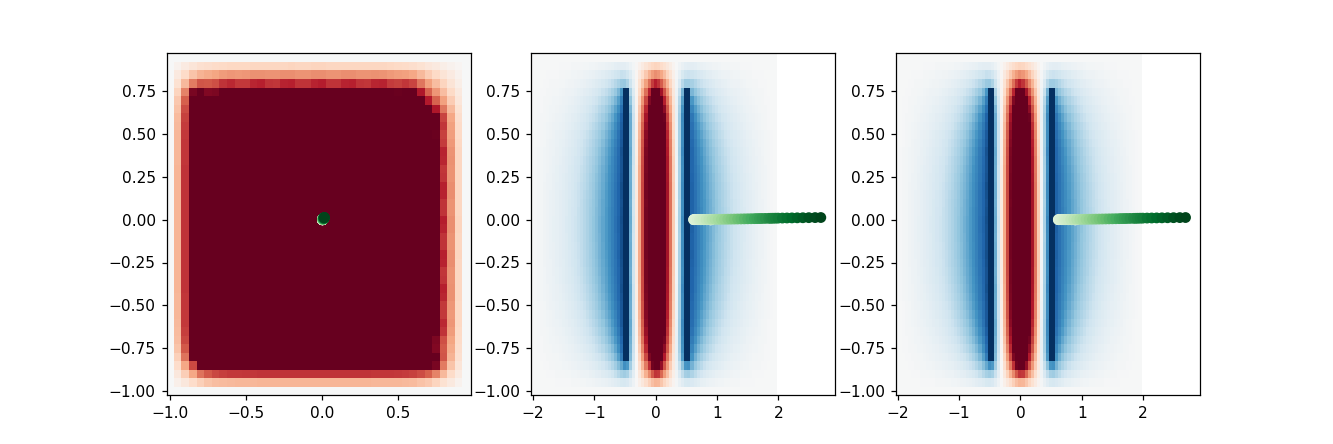

In [3]:
NPARTICLES = 1
SIM_TIME = 2
particle_opts = {
    "mass": 1,
    "charge": 1,
    "initial_loc": (0.9, 0, 0),
    "initial_loc_std": (0, 0, 0),
    "initial_v": (-1, 0, 0),
    "initial_v_std": (0.00, 0.00, 0.00),
    "bounce_coef": 1
}

v_range = np.arange(0, 0.75, 0.25)
num_hit = []
initial_KE_avg = []

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.show()

all_deflect = None
for voltage in v_range:
    #print("Voltage set to:", voltage)
    sim = generate_space(voltage, scale=20)
    particles = [generate_particle(sim, particle_opts["mass"], particle_opts["charge"],
                                   particle_opts["initial_loc"], particle_opts["initial_loc_std"],
                                   particle_opts["initial_v"], particle_opts["initial_v_std"],
                                   particle_opts["bounce_coef"]) for _ in range(NPARTICLES)]
    initial_KEs = [(p.mass * (np.linalg.norm(p.initial_velocity))**2) / 2 for p in particles]
    initial_KE_avg.append(sum(initial_KEs) / NPARTICLES)
    
    hit = 0
    for particle in particles:
        particle.compute_motion((0, SIM_TIME))
        if particle.num_bounces > 0:
            hit += 1
            
    if all_deflect is None and hit == 0:
        all_deflect = voltage
    num_hit.append(hit)
    
    for i, ax in enumerate(axes):
        ax.clear()
        sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i)
        Visualizations.colormesh_2d(sim2d, color_norm=voltage, graph_ax=ax)
        for p in particles:
            Visualizations.trajectory_2d(p.time, p.position, axis=i, graph_ax=ax)
            
    fig.canvas.draw()
    #print("->", hit, "were not deflected")
    

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(v_range, num_hit)
plt.show()